#Step 1 : image resize
#Step 2 : PSPNet model 입력
### 1. input : C H W : 3 X 475 X 475  
### 2. Encoder module: 
#### output - 1 -> pyramid pooling 2048 x 60 x 60 
#### output - 2 -> AuxLoss mudule 1024 x 60 x 60
### 3. Pyramid Pooling module: 4096 x 60 x 60
### 4-1. Decoder module: 21 x 475 x 475
### 4-2. AuxLoss module: 21 x 475 x 475

#Step 3 : classes extract
#Step 4 : image resize


# 새 섹션

In [27]:
# !git clone https://github.com/YutaroOgawa/pytorch_advanced.git
# !pip install pytorch_model_summary
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import os
import os.path as osp
import urllib.request
import zipfile
import tarfile

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data
import torchvision
import torch.utils.data as data
import math
import time

import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pytorch_model_summary
from tqdm import tqdm 
import random

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [51]:
CFG = {
    'IMG_SIZE':2048,
    'EPOCHS':30,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':12,
    'SEED':41,
    'DRIVE_PATH' : '/gdrive/MyDrive/pytorch-deeplearning/ch3 PSPNet/'
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

try:
    checkpoint = torch.load('/gdrive/MyDrive/pytorch-deeplearning/ch3 PSPNet/weight%d.pt' % 30)
    
except:
    checkpoint = {}

In [30]:
data_dir = "./data/"
target_file = "VOCtrainval_11-May-2012.tar"
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, target_file)

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    with tarfile.open(target_path) as tar:
        tar.extractall(path = '.')

In [31]:
def make_datapath_list(rootpath):

    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

rootpath = "/content/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])

/content/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
/content/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


In [32]:
# %cd /content/pytorch_advanced/3_semantic_segmentation
# from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor
# %cd /content

import torch
from torchvision import transforms
from PIL import Image, ImageOps, ImageFilter
import numpy as np


class Compose(object):

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, anno_class_img):
        for t in self.transforms:
            img, anno_class_img = t(img, anno_class_img)
        return img, anno_class_img


class Scale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, img, anno_class_img):

        width = img.size[0]  
        height = img.size[1]  

        scale = np.random.uniform(self.scale[0], self.scale[1])

        scaled_w = int(width * scale)  
        scaled_h = int(height * scale)  
        img = img.resize((scaled_w, scaled_h), Image.BICUBIC)

        anno_class_img = anno_class_img.resize(
            (scaled_w, scaled_h), Image.NEAREST)

        if scale > 1.0:
            left = scaled_w - width
            left = int(np.random.uniform(0, left))

            top = scaled_h-height
            top = int(np.random.uniform(0, top))

            img = img.crop((left, top, left+width, top+height))
            anno_class_img = anno_class_img.crop(
                (left, top, left+width, top+height))

        else:
            p_palette = anno_class_img.copy().getpalette()

            img_original = img.copy()
            anno_class_img_original = anno_class_img.copy()

            pad_width = width-scaled_w
            pad_width_left = int(np.random.uniform(0, pad_width))

            pad_height = height-scaled_h
            pad_height_top = int(np.random.uniform(0, pad_height))

            img = Image.new(img.mode, (width, height), (0, 0, 0))
            img.paste(img_original, (pad_width_left, pad_height_top))

            anno_class_img = Image.new(
                anno_class_img.mode, (width, height), (0))
            anno_class_img.paste(anno_class_img_original,
                                 (pad_width_left, pad_height_top))
            anno_class_img.putpalette(p_palette)

        return img, anno_class_img


class RandomRotation(object):
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img, anno_class_img):

        rotate_angle = (np.random.uniform(self.angle[0], self.angle[1]))

        img = img.rotate(rotate_angle, Image.BILINEAR)
        anno_class_img = anno_class_img.rotate(rotate_angle, Image.NEAREST)

        return img, anno_class_img


class RandomMirror(object):

    def __call__(self, img, anno_class_img):
        if np.random.randint(2):
            img = ImageOps.mirror(img)
            anno_class_img = ImageOps.mirror(anno_class_img)
        return img, anno_class_img


class Resize(object):

    def __init__(self, input_size):
        self.input_size = input_size

    def __call__(self, img, anno_class_img):
        img = img.resize((self.input_size, self.input_size),
                         Image.BICUBIC)
        anno_class_img = anno_class_img.resize(
            (self.input_size, self.input_size), Image.NEAREST)

        return img, anno_class_img


class Normalize_Tensor(object):
    def __init__(self, color_mean, color_std):
        self.color_mean = color_mean
        self.color_std = color_std

    def __call__(self, img, anno_class_img):
        # pdb.set_trace()
        img = transforms.functional.to_tensor(img)
        img = transforms.functional.normalize(
            img, self.color_mean, self.color_std)

        anno_class_img = np.array(anno_class_img)  

        index = np.where(anno_class_img == 255)
        anno_class_img[index] = 0

        anno_class_img = torch.from_numpy(anno_class_img)

        return img, anno_class_img

In [33]:
class DataTransform():

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]), 
                RandomRotation(angle=[-10, 10]), 
                RandomMirror(),  
                Resize(input_size),  
                Normalize_Tensor(color_mean, color_std)  
            ]),
            'val': Compose([
                Resize(input_size),  
                Normalize_Tensor(color_mean, color_std)  
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        return self.data_transform[phase](img, anno_class_img)

class A_DataTransform():

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': A.Compose([
                A.Resize(input_size, input_size), 
                A.Rotate(p= 0.5), 
                A.HorizontalFlip(p = 0.5),  
                # A.Normalize(color_mean, color_std)  
            ]),
            'val': A.Compose([
                A.Resize(input_size, input_size), 
                A.Normalize(color_mean, color_std)  
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        return self.data_transform[phase](image = img, mask = anno_class_img)

numpy.ndarray

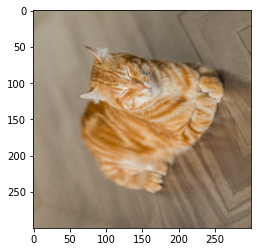

In [34]:
cat = Image.open('/content/cat.jpg')
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]
trans = A_DataTransform(300, color_mean, color_std)
# plt.imshow(cat)
cat = np.array(cat)
img= trans('train', cat,cat)
plt.imshow(img['image'])
# plt.imshow(img['mask'])
type(img['image'])


In [35]:
class VOCDataset(data.Dataset):

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):

        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   

        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   

        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img

color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# データの取り出し例
# /content/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg
# print(val_dataset.__getitem__(0)[0].shape)
# print(val_dataset.__getitem__(0)[1].shape)
# print(val_dataset.__getitem__(0))
# from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

torch.Size([8, 3, 475, 475]) torch.Size([8, 475, 475])


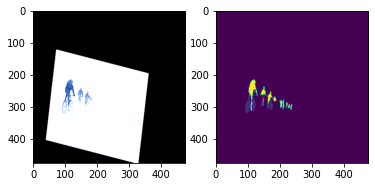

In [36]:
batch_size = 8
train_dataloader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, pin_memory= True, num_workers = 2)
val_dataloader = data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False,  num_workers = 2)

dataloaders_dict = {'train' : train_dataloader, 'val' : val_dataloader}

for i, a in dataloaders_dict['train']:
    print(i.size(), a.size())
    plt.subplot(1,2,1)
    plt.imshow(i[0].permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(a[0])
    img = i
    anno = a
    break

In [37]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias = bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class FeatureMap_convolution(nn.Module):
    def __init__(self):
        super(FeatureMap_convolution, self).__init__()
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self._1 =  conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self._2 =  conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self._3 =  conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

    def forward(self, x):
        x = self._1(x)
        x = self._2(x)
        x = self._3(x)
        x = self.maxpool(x)
        return x


In [38]:
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()
        self.add_module('block1', bottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation))

        for i in range(n_blocks-1):
            self.add_module('block' + str(i+2), bottleNeckIdentifyPSP(out_channels, mid_channels, stride, dilation))

class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias = bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        return x

class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()
        """
        bottleNeck 구현
        """
        self.cbr_1 = conv2DBatchNormRelu(in_channels, mid_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False)
        self.cbr_2 = conv2DBatchNormRelu(mid_channels, mid_channels, kernel_size = 3, stride = stride, padding = dilation, dilation = dilation, bias = False)
        self.cbr_3 = conv2DBatchNorm(mid_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False)

        self.cb_residual = conv2DBatchNorm(in_channels, out_channels, kernel_size =1, stride = stride, padding=0, dilation=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        conv = self.cbr_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)

class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()
        """
        bottleNeck 구현
        """
        self.cbr_1 = conv2DBatchNormRelu(in_channels, mid_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False)
        self.cbr_2 = conv2DBatchNormRelu(mid_channels, mid_channels, kernel_size = 3, stride = 1, padding = dilation, dilation = dilation, bias = False)
        self.cbr_3 = conv2DBatchNorm(mid_channels, in_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        """
        Identify 구현 방법
        """
        conv = self.cbr_1(x)
        conv = self.cbr_2(conv)
        conv = self.cbr_3(conv)
        return self.relu(conv + x)       


In [39]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling,self).__init__()
        self.height = height
        self.width = width
        out_channels = int(in_channels / len(pool_sizes))
        
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size = pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False)
        
        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size = pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size = pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size = pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False)

    def forward(self, x):
        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size = (self.height, self.width), mode = 'bilinear', align_corners = True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size = (self.height, self.width), mode = 'bilinear', align_corners = True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size = (self.height, self.width), mode = 'bilinear', align_corners = True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size = (self.height, self.width), mode = 'bilinear', align_corners = True)

        output = torch.cat([x, out1, out2, out3, out4], dim=1)
        return output

In [40]:
class DecoderPSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecoderPSPFeature, self).__init__()
        self.height = height
        self.width = width
        self.cbr = conv2DBatchNormRelu(in_channels = 4096, out_channels = 512, kernel_size = 3, stride = 1, padding = 1, dilation = 1, bias = False)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.classification = nn.Conv2d(in_channels = 512, out_channels = n_classes, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(x, size = (self.height, self.width), mode = 'bilinear', align_corners= True)
        return output

class AuxilaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxilaryPSPlayers, self).__init__()
        self.height = height
        self.width = width
        self.cbr = conv2DBatchNormRelu(in_channels = in_channels, out_channels = 256, kernel_size = 3, stride = 1, padding = 1, dilation = 1, bias = False)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.classification = nn.Conv2d(in_channels = 256, out_channels = n_classes, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(x, size = (self.height, self.width), mode = 'bilinear', align_corners= True)
        return output
        

In [41]:
class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()
        block_config = [3, 4, 6, 3]
        img_size = 475
        img_size_8 = 60

        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(n_blocks = block_config[0], in_channels = 128, mid_channels = 64,
                                              out_channels = 256, stride = 1, dilation = 1)
        self.feature_res_2 = ResidualBlockPSP(n_blocks = block_config[1], in_channels = 256, mid_channels = 128,
                                              out_channels = 512, stride = 2, dilation = 1)
        self.feature_dilated_res_1 = ResidualBlockPSP(n_blocks = block_config[2], in_channels = 512, mid_channels = 256,
                                              out_channels = 1024, stride = 1, dilation = 2)
        self.feature_dilated_res_2 = ResidualBlockPSP(n_blocks = block_config[3], in_channels = 1024, mid_channels = 512,
                                              out_channels = 2048, stride = 1, dilation = 4)
        self.pyramid_pooling = PyramidPooling(in_channels = 2048, pool_sizes = [6, 3, 2, 1], height = img_size_8, width = img_size_8)
        self.decode_feature = DecoderPSPFeature(height = img_size, width = img_size, n_classes = n_classes)
        self.aux = AuxilaryPSPlayers(in_channels = 1024, height = img_size, width = img_size, n_classes = n_classes)
        
    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)

        x = self.feature_dilated_res_2(x)
        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)

In [42]:
# net = PSPNet(n_classes = 21)
# net
# print(pytorch_model_summary.summary(net,torch.zeros(1,3,475,475), show_input=True, max_depth=None, show_parent_layers=True))

In [43]:
# dummy = torch.rand(2, 3, 475, 475)
# outputs = net(dummy)
# print(outputs[0].size())
# print(outputs[1].size())

In [44]:
# model_path = '/gdrive/MyDrive/pytorch-deeplearning/ch3 PSPNet/pspnet50_ADE20K.pth'
# net.load_state_dict(torch.load(model_path))

In [45]:
# !curl https://drive.google.com/open?id=192JenT9UTHjFb6fhwSdRgOWr8_RmDl4I
%pwd

'/content'

In [68]:
net = PSPNet(n_classes = 21)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# state_dict = torch.load('/gdrive/MyDrive/pytorch-deeplearning/ch3 PSPNet/pspnet50_30.pth', map_location=torch.device(device))
# net.load_state_dict(state_dict)

n_classes = 21
net.decode_feature.classification = nn.Conv2d(in_channels = 512, out_channels = n_classes, kernel_size = 1, stride = 1, padding = 0)
net.aux.classification = nn.Conv2d(in_channels = 256, out_channels = n_classes, kernel_size = 1, stride = 1, padding = 0)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
        print(type(m),m)

def weights_init_he(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None :
            nn.init.constant_(m.bias, 0.0)
# for n in net.parameters():
#     print(n)

# net.extras.apply(weights_init)
# net.loc.apply(weights_init)
# net.conf.apply(weights_init)
for n in net.modules():
    if isinstance(n, nn.Conv2d):
        weights_init_he(n)

# net.decode_feature.classification.apply(weights_init)
# net.aux.classification.apply(weights_init)
weight_path = '/gdrive/MyDrive/pytorch-deeplearning/weight/ssd300_%d.pth' % 40
# net.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))

model_state = torch.load('/gdrive/MyDrive/pytorch-deeplearning/ch3 PSPNet/pspnet50_30.pth', map_location=torch.device(device))
model_state.keys

<function OrderedDict.keys>

In [58]:
class PSPLoss(nn.Module):
    def __init__(self, aux_weight = .4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight

    def forward(self, outputs, targets):
        loss = F.cross_entropy(outputs[0], targets, reduction = 'mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction = 'mean')
        return loss + self.aux_weight * loss_aux

criterion = PSPLoss(aux_weight = 0.4)

In [59]:
# optimizer = optim.Adam(net.parameters())
optimizer = optim.Adam([
    {'params' : net.feature_conv.parameters(), 'lr' : 1e-3},
    {'params' : net.feature_res_1.parameters(), 'lr' : 1e-3},
    {'params' : net.feature_res_2.parameters(), 'lr' : 1e-3},
    {'params' : net.feature_dilated_res_1.parameters(), 'lr' : 1e-3},
    {'params' : net.feature_dilated_res_2.parameters(), 'lr' : 1e-3},
    {'params' : net.pyramid_pooling.parameters(), 'lr' : 1e-2},
    {'params' : net.aux.parameters(), 'lr' : 1e-2}], weight_decay = 1e-4)

def lambda_epoch(epoch):
    max_epoch = 3000

    return ((1 - epoch/max_epoch)** 0.9) 

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda_epoch)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda_epoch)

In [60]:
import pdb

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def setup():
    image_file_path = '/content/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg'
    img = Image.open(image_file_path)
    img_width, img_height = img.size
    data_transform = DataTransform(475, color_mean, color_std)
    anno_file_path = val_anno_list[0]
    anno_class_img = Image.open(anno_file_path)
    p_plaette = anno_class_img.getpalette()
    phase = 'val'
    img_test, anno_class_img = data_transform(phase, img, anno_class_img)
    x = img_test.unsqueeze(0).to(device)
    net.eval()
    outputs = net(x)
    y = outputs[0][0].detach().cpu().numpy()
    y = np.argmax(y, axis = 0)

    anno_class_img = Image.fromarray(np.uint8(y), mode="P")
    anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)

    trans_img = Image.new('RGBA', anno_class_img.size, (0,0,0,0))
    anno_class_img = anno_class_img.convert('RGBA')
    return img, anno_class_img, trans_img

def check(device, img, anno_class_img, trans_img):
    # pdb.set_trace()
    img_width, img_height = img.size
    for x in range(img_width):
        for y in range(img_height):
            pixel = anno_class_img.getpixel((x,y))
            r,g,b,a = pixel

            if pixel[0] ==0 and pixel[1] ==0 and pixel[2] == 0:
                continue
            
            else:
                trans_img.putpixel((x,y), (r,g,b, 150))

    # img = Image.open(image_file_path)
    result = Image.alpha_composite(img.convert('RGBA'), trans_img)
    # pdb.set_trace()
    # grid = torchvision.utils.make_grid(transforms.ToTensor([img,anno_class_img]))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(anno_class_img)
    plt.subplot(1,3,3)
    plt.imshow(result)
    plt.show()

In [62]:
from torch.cuda.amp import autocast, GradScaler
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):
# def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device : {device}')
    torch.autograd.set_detect_anomaly(True)


    net.to(device)
    autocast(enabled=True, dtype=torch.float16, cache_enabled=True)
    torch.backends.cudnn.benchmark = True
    num_train_imgs = len(dataloaders_dict['train'].dataset)
    num_val_imgs = len(dataloaders_dict['val'].dataset)
    batch_size = dataloaders_dict['train'].batch_size

    iteration = 1
    logs = []
    batch_multiplier = 3

    scaler = GradScaler()
    checkpoint = checkpoint['epoch']
    img, anno_class_img, trans_img  = setup ()
    # pdb.set_trace()
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        print('--------------------------------------')
        print(f'Epoch {epoch +1} / {num_epochs} ')
        print('--------------------------------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                optimizer.zero_grad()
                print('train start')
            
            else :
                if((epoch +1) % 1 == 0):
                    net.eval()
                    # pdb.set_trace()

                    check(device, img, anno_class_img, trans_img)

                    print('val start')
                else:
                    continue
                

            count = 0
            iter = 0
            for images, anno_class_images in tqdm(dataloaders_dict[phase]):
                if iter == 10:
                    break

                if images.size()[0] ==1:
                    continue
                
                images = images.to(device)
                anno_class_images = anno_class_images.to(device)
                
                # pdb.set_trace()

                if phase == 'train' and count == 0:
                    
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = net(images)
                        loss = criterion(outputs, anno_class_images.long()) / batch_multiplier

                    if phase == 'train':
                        loss.backward()
                        count -=1
                        if iteration % 10 == 0 :
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print(f' epoch : {iteration} || Loss : {loss.item() / batch_size * batch_multiplier:.4f} || 10iter time : {duration:.4f} s')
                            t_iter_start = time.time()
                        
                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration +=1
                    
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier
                    
                iter +=1

            # check(device)
            scheduler.step()

        t_epoch_finish = time.time()
        print('--------------------------------------')
        print(f' epoch : {epoch +1} || Epoch_train_loss : {epoch_train_loss / num_train_imgs:.7f} || Epoch_val_loss : {epoch_val_loss / num_val_imgs:.7f}')
        print(f' timer : {t_epoch_finish - t_epoch_start:.4f} s')
        t_epoch_start = time.time()

        log_epoch = {'epoch' : epoch +1, 'train_loss' : epoch_train_loss / num_train_imgs, 'val_loss' : epoch_val_loss / num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv('log_output.csv')
    # torch.save(net.state_dict(), 'pspnet50' + str(epoch+1) + '.pth')
    torch.save(
    {
            "model": "CustomModel",
            "epoch": epoch,
            "model_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "description": f"CustomModel 체크포인트-{checkpoint}",
        }, f"./checkpoint-{checkpoint}.pt",
    )

In [63]:
num_epochs = 3000
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs)
# train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

device : cpu


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


--------------------------------------
Epoch 1 / 3000 
--------------------------------------
train start


  0%|          | 0/183 [03:14<?, ?it/s]


KeyboardInterrupt: ignored